In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import joblib 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.data.experimental import AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation,ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D,MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [ ]:
os.chdir('/content/drive/MyDrive/SALT_Challange')
os.makedirs('TRAIN/',exist_ok=True)
os.makedirs('TEST/',exist_ok=True)
os.makedirs('FLAMINGO/',exist_ok=True)
os.makedirs('COMPETITION_DATA/',exist_ok=True)

In [ ]:
!ls

COMPETITION_DATA      FLAMINGO	    sample_submission.csv  train.csv
competition_data.zip  flamingo.zip  TEST		   train_valid_df.pkl
decoded_images.pkl    model_save    test.zip		   train.zip
depths.csv	      new.ipynb     TRAIN		   Untitled1.ipynb


In [ ]:
len(os.listdir('TRAIN/images'))

4000

In [ ]:
print('Number of train images',len(os.listdir('TRAIN/images')))
print('Number of test images',len(os.listdir('TEST/images')))

Number of train images 4000
Number of test images 18000


In [ ]:
# get image ids
train_image_ids = sorted(os.listdir('TRAIN/images'))
train_mask_ids = sorted(os.listdir('TRAIN/masks'))
# print sample
print('Examle of image ids ==> ',train_image_ids[:2])
print('Examle of image masks ==> ',train_mask_ids[:2])

Examle of image ids ==>  ['000e218f21.png', '008a50a2ec.png']
Examle of image masks ==>  ['010ee525b6.png', '016fc8031c.png']


In [ ]:
X = np.zeros((len(train_image_ids), 128, 128, 1), dtype=np.float32)
y = np.zeros((len(train_image_ids), 128, 128, 1), dtype=np.float32)

In [ ]:
for ind, img_id in tqdm(enumerate(train_image_ids)):
    # Load images
    img = load_img("TRAIN/images/"+img_id, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = load_img("TRAIN/masks/"+img_id, grayscale=True)
    mask = img_to_array(mask)
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[ind] = x_img/255.0
    y[ind] = mask/255.0


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
X.shape

(4000, 128, 128, 1)

In [ ]:
y.shape

(4000, 128, 128, 1)

In [ ]:
joblib.dump((X,y),'decoded_images.pkl')

['decoded_images.pkl']

In [ ]:
X,y = joblib.load('decoded_images.pkl')

In [ ]:
y = y.astype(bool)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
print('X_train Shape ',X_train.shape)
print('X_valid Shape', X_valid.shape)

X_train Shape  (3600, 128, 128, 1)
X_valid Shape (400, 128, 128, 1)


Text(0.5, 1.0, 'Salt')

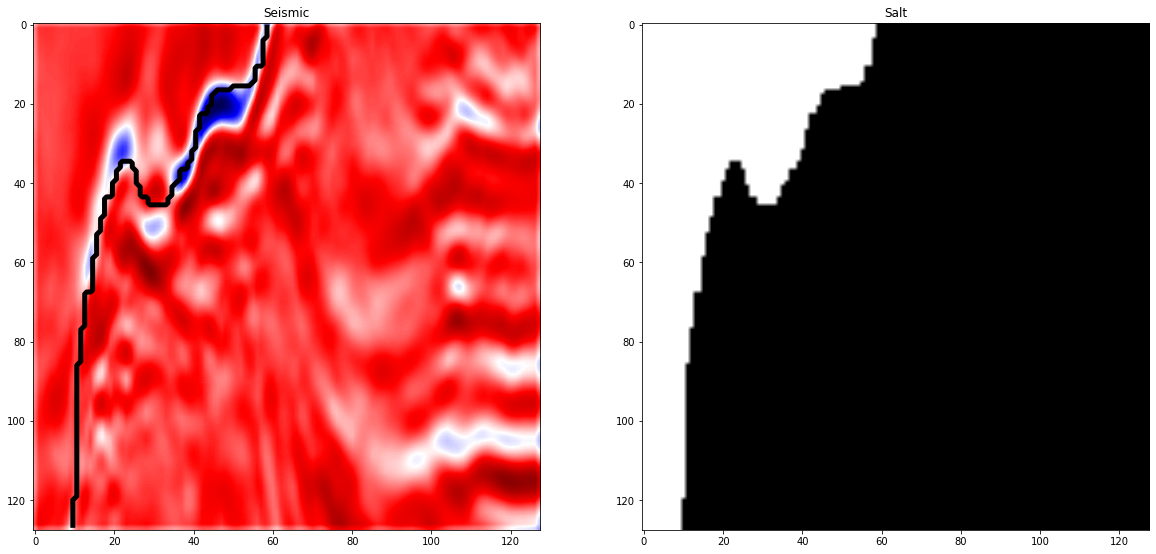

In [ ]:
# Visualize any randome image along with the mask
ix = np.random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [ ]:
def unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = False):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [ ]:

# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

###############
# BINARY LOSSES
###############
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss, strict=True, name="loss")
    return loss
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    logits = y_pred
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

def symmetric_lovasz(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    loss = ((lovasz_hinge(y_pred, y_true, per_image = True, ignore = None)) + \
            (lovasz_hinge(-y_pred, 1 - y_true, per_image = True, ignore = None))) /2
    return loss


In [ ]:
input_img = Input((128, 128, 1), name='in_img')
model = unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_img (InputLayer)             [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         in_img[0][0]                     
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [ ]:
#!rm -rf 'model_save'
#del model

In [ ]:
os.makedirs('model_save/',exist_ok=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model_save/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
225/225 [==============================] - 17s 71ms/step - loss: 0.4145 - mean_io_u_1: 0.3728 - val_loss: 1.8061 - val_mean_io_u_1: 0.3814

Epoch 00001: val_loss improved from inf to 1.80612, saving model to model_save/best_model.h5
Epoch 2/30
225/225 [==============================] - 16s 69ms/step - loss: 0.2796 - mean_io_u_1: 0.3740 - val_loss: 0.3997 - val_mean_io_u_1: 0.3814

Epoch 00002: val_loss improved from 1.80612 to 0.39965, saving model to model_save/best_model.h5
Epoch 3/30
225/225 [==============================] - 15s 68ms/step - loss: 0.2512 - mean_io_u_1: 0.3724 - val_loss: 0.3422 - val_mean_io_u_1: 0.3814

Epoch 00003: val_loss improved from 0.39965 to 0.34221, saving model to model_save/best_model.h5
Epoch 4/30
225/225 [==============================] - 15s 68ms/step - loss: 0.2246 - mean_io_u_1: 0.3747 - val_loss: 0.3430 - val_mean_io_u_1: 0.3814

Epoch 00004: val_loss did not improve from 0.34221
Epoch 5/30
225/225 [==============================] - 15s 

In [ ]:
model_json = model.to_json()
with open('model_save/unet_model.json','w') as json_file:
    json_file.write(model_json)
print('Model saved to disk in json format')

Model saved to disk in json format


In [ ]:
model.load_weights('model_save/best_model.h5')

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 13s 508ms/step - loss: 0.1291 - mean_io_u: 0.3838


[0.1446862369775772, 0.3814437985420227]

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 0s 38ms/step


In [ ]:
preds_train_th = (preds_train > 0.5).astype(np.uint8)
preds_val_th = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, prediction, binary_prediction, index=None):
    """Function to plot the results"""
    if index is None:
        index = random.randint(0, len(X))

    has_mask = y[index].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    # plot origiba seismic image
    ax[0].imshow(X[index, ..., 0], cmap='seismic')
    # if mask
    if has_mask:
        # draw seperation line
        ax[0].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    # plot original mask image
    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Salt')
    
    # plot predicted image
    ax[2].imshow(prediction[index].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    # plot binary predicted image
    ax[3].imshow(binary_prediction[index].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

# prediction on train data

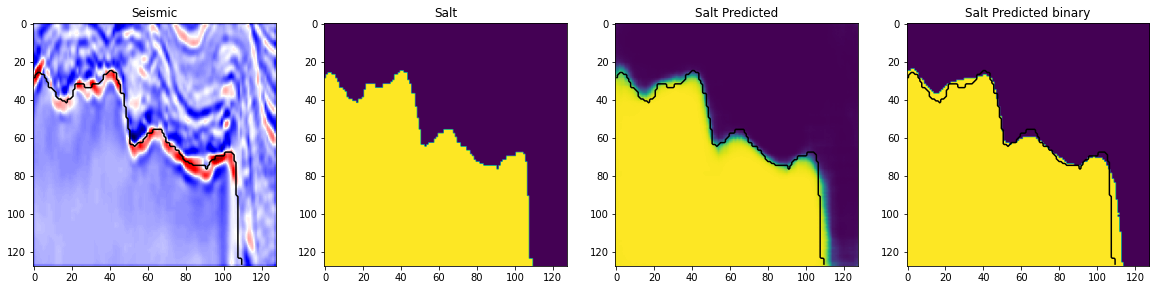

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=50)


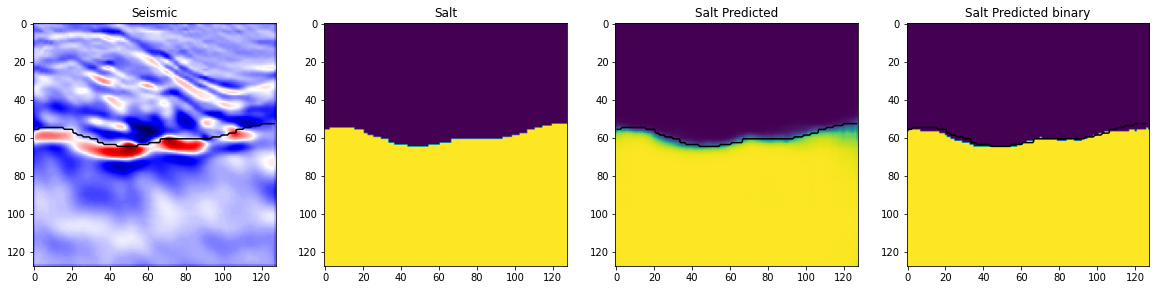

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_th, index=5)

In [ ]:
train_df,valid_df = joblib.load('train_valid_df.pkl')

In [ ]:
valid_df.head(6)

,image,mask
0,TRAIN/images/25db231ea0.png,TRAIN/masks/25db231ea0.png
1,TRAIN/images/dfd3138198.png,TRAIN/masks/dfd3138198.png
2,TRAIN/images/2425501bf4.png,TRAIN/masks/2425501bf4.png
3,TRAIN/images/fbb8eba26d.png,TRAIN/masks/fbb8eba26d.png
4,TRAIN/images/bea9b0571b.png,TRAIN/masks/bea9b0571b.png
5,TRAIN/images/05a61e5799.png,TRAIN/masks/05a61e5799.png


In [ ]:
v = load_img('TRAIN/masks/05a61e5799.png',color_mode='grayscale')
v = img_to_array(v)
v = resize(v,(128,128),mode='constant',preserve_range=True)
v.shape

(128, 128, 1)

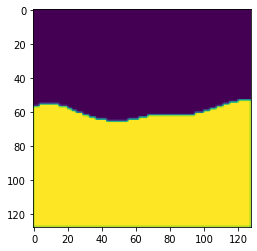

In [ ]:
plt.imshow(v.squeeze())